# Day087
## 訓練神經網路的細節與技巧 - 使用 callbacks 函數做 reduce learning rate
### Reduce Learning Rate:
隨訓練更新次數，將 Learning rate 逐步減小
> 因為通常損失函數越接近谷底的位置，開口越小 – 需要較小的Learning rate 才可以再次下降

### 可行的調降方式
- 每更新 n 次後，將 Learning rate 做一次調降 – schedule decay
- 當經過幾個 epoch 後，發現 performance 沒有進步 – Reduce on plateau

### Keras
> 可以使用 ReduceLROnPlateau或  LearningRateScheduler

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import keras

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dense, Input, BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = Input(input_shape)
    
    for i, units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else: 
            x = Dense(units=units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### 改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
"""
Set model checkpoint callbacks
Write your training loop and show the results
"""
patience_list = [5, 10]
factor_list = [0.2, 0.5]

# 訓練網路
results = {}

for patience in patience_list:
    for factor in factor_list:
        reduce_lr = ReduceLROnPlateau(factor=factor,
                                     min_lr=1e-12,
                                     monitor='val_loss',
                                     patience=patience,
                                     verbose=1)
        model = build_mlp(input_shape=x_train.shape[1:])
        print(f'Now is factor: {factor}, patience: {patience}')
        model.summary()
        
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        model.fit(x_train, y_train,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 validation_data=(x_test, y_test),
                 shuffle=True,
                 callbacks=[reduce_lr])
        
        # collect result
        train_loss = model.history.history['loss']
        train_acc = model.history.history['acc']
        valid_loss = model.history.history['val_loss']
        valid_acc = model.history.history['val_acc']
        
        exp_name_tag = f"exp-patience-{patience}-factor-{factor}"
        results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
Now is factor: 0.2, patience: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________________


Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 44/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.8595 - acc: 0.7200 - val_loss: 1.4570 - val_acc: 0.5009
Epoch 45/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.8600 - acc: 0.7198 - val_loss: 1.4571 - val_acc: 0.5003
Epoch 46/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.8594 - acc: 0.7204 - val_loss: 1.4571 - val_acc: 0.5006
Epoch 47/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.8599 - acc: 0.7212 - val_loss: 1.4572 - val_acc: 0.5002
Epoch 48/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.8602 - acc: 0.7190 - val_loss: 1.4572 - val_acc: 0.5004

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 49/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.8598 - acc: 0.7200 - val_loss: 1.4572 - val_acc: 0.5002
Epoch 50/

Epoch 40/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7611 - acc: 0.7599 - val_loss: 1.4880 - val_acc: 0.5028
Epoch 41/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7585 - acc: 0.7616 - val_loss: 1.4882 - val_acc: 0.5032
Epoch 42/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7553 - acc: 0.7617 - val_loss: 1.4861 - val_acc: 0.5036
Epoch 43/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7527 - acc: 0.7625 - val_loss: 1.4897 - val_acc: 0.5032

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 44/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7482 - acc: 0.7658 - val_loss: 1.4916 - val_acc: 0.5031
Epoch 45/50
50000/50000 [==============================] - 2s 39us/step - loss: 0.7452 - acc: 0.7661 - val_loss: 1.4896 - val_acc: 0.5046
Epoch 46/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7440 - acc

Epoch 37/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7875 - acc: 0.7469 - val_loss: 1.4834 - val_acc: 0.5047
Epoch 38/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7833 - acc: 0.7509 - val_loss: 1.4774 - val_acc: 0.5072
Epoch 39/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7795 - acc: 0.7502 - val_loss: 1.4828 - val_acc: 0.5044
Epoch 40/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.7748 - acc: 0.7519 - val_loss: 1.4871 - val_acc: 0.5038

Epoch 00040: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 41/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.7691 - acc: 0.7540 - val_loss: 1.4849 - val_acc: 0.5049
Epoch 42/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7634 - acc: 0.7576 - val_loss: 1.4834 - val_acc: 0.5054
Epoch 43/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.7616 - a

Epoch 34/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.7809 - acc: 0.7489 - val_loss: 1.5039 - val_acc: 0.4903
Epoch 35/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7700 - acc: 0.7544 - val_loss: 1.5114 - val_acc: 0.4944
Epoch 36/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7590 - acc: 0.7595 - val_loss: 1.5100 - val_acc: 0.4926
Epoch 37/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.7491 - acc: 0.7619 - val_loss: 1.5116 - val_acc: 0.4909
Epoch 38/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7389 - acc: 0.7659 - val_loss: 1.5267 - val_acc: 0.4946
Epoch 39/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.7289 - acc: 0.7700 - val_loss: 1.5247 - val_acc: 0.4937
Epoch 40/50
50000/50000 [==============================] - 2s 40us/step - loss: 0.7195 - acc: 0.7730 - val_loss: 1.5405 - val_acc: 0.4954
Epoch 41/50
50000/50000 [=========

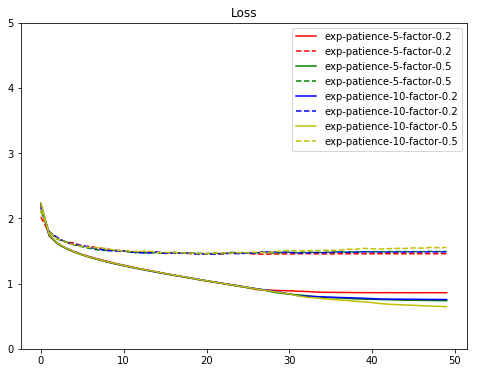

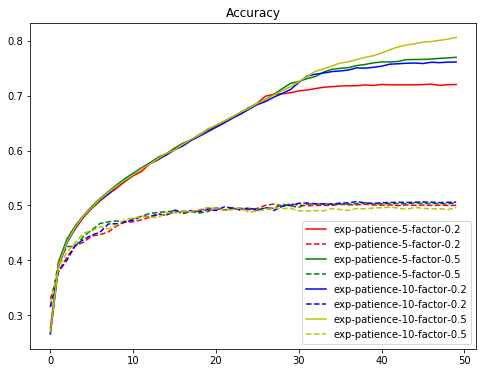

In [8]:
# 繪製結果
"""
plot the results
"""
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

> 效果感覺都差不多

### 將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [9]:
results = {}

reduce_lr = ReduceLROnPlateau(factor=0.2,
                              min_lr=1e-12,
                              monitor='val_loss',
                              patience=5,
                              verbose=1)

for i in range(2):
    if i == 0:
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        opt = "Adam"
    elif i == 1:
        optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)
        opt = "RMSprop"
        
    model = build_mlp(input_shape=x_train.shape[1:])
    print(f'Now is {opt}')
    model.summary()
                
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[reduce_lr])
        
    # collect result
    train_loss = model.history.history['loss']
    train_acc = model.history.history['acc']
    valid_loss = model.history.history['val_loss']
    valid_acc = model.history.history['val_acc']
        
    exp_name_tag = f"exp-optimizer-{opt}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Now is Adam
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512      

50000/50000 [==============================] - 2s 37us/step - loss: 0.5614 - acc: 0.8329 - val_loss: 1.4025 - val_acc: 0.5359
Epoch 47/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5626 - acc: 0.8323 - val_loss: 1.4025 - val_acc: 0.5357
Epoch 48/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5622 - acc: 0.8314 - val_loss: 1.4025 - val_acc: 0.5359
Epoch 49/50
50000/50000 [==============================] - 2s 38us/step - loss: 0.5622 - acc: 0.8323 - val_loss: 1.4025 - val_acc: 0.5360
Epoch 50/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5622 - acc: 0.8319 - val_loss: 1.4024 - val_acc: 0.5357

Epoch 00050: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.
Now is RMSprop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
___________________________

50000/50000 [==============================] - 2s 37us/step - loss: 0.5509 - acc: 0.8304 - val_loss: 1.4249 - val_acc: 0.5433
Epoch 42/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5523 - acc: 0.8297 - val_loss: 1.4251 - val_acc: 0.5431
Epoch 43/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5520 - acc: 0.8303 - val_loss: 1.4252 - val_acc: 0.5431
Epoch 44/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5512 - acc: 0.8303 - val_loss: 1.4253 - val_acc: 0.5423
Epoch 45/50
50000/50000 [==============================] - 2s 36us/step - loss: 0.5521 - acc: 0.8287 - val_loss: 1.4253 - val_acc: 0.5426

Epoch 00045: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 46/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5516 - acc: 0.8308 - val_loss: 1.4253 - val_acc: 0.5425
Epoch 47/50
50000/50000 [==============================] - 2s 37us/step - loss: 0.5513 - acc: 0.8308 - 

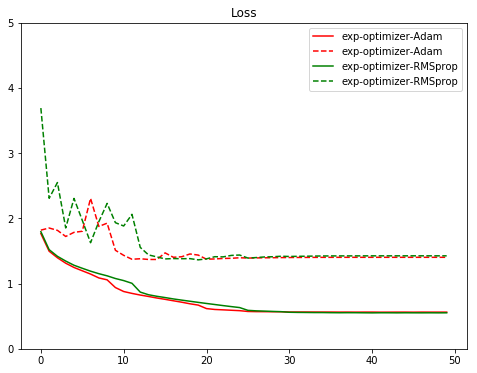

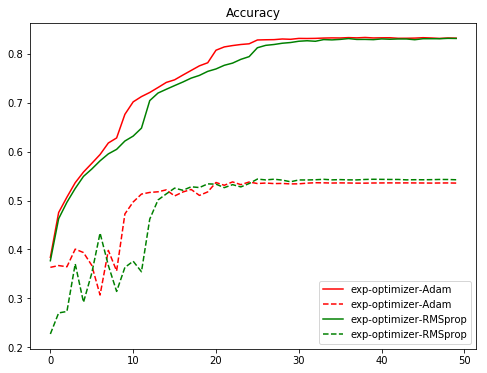

In [10]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()